# Data Pre-Processing & Feature Engineering

Based on EDA we have got following information on Market and News Data

### Market Data

- There are no significant missing values in the datset. However, there are 269 distinct asset codes with no asset names. Therefore market data with news data on asset name can cause problems
- Volume has the highest correlation to the response variable i.e. returnsOpenNextMktres10
- Closing Price of stock at one day is not same as Opening Price of next day. It suggests that we might have potential outliers incase the the difference between the two is very high.
- Mostly null data comes from market adjusted columns. We might need to fill them up with some values.
- Returns should not take extremely higher values. If it does, it is either noise, or extreme data that will confuse our prediction later on. We might need to remove these extreme data.

### News Data

- Unlike Market Data, we do not have 'Unknown' asset names in News Data.
- We find missing values in Headline. We would like to remove these rows, since prediction is impossible.
- Some news are delayed which is calculated by taking difference between firstCreated and time. We might like to get rid of such articles.
- There are almost negligible news articles with Urgency code equals 2

Based on above findings, we do following Data Pre-processings.

# Part A: Data Pre-Processing

## 1. Market Data

#### Load Data

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv("market_train1.csv")
df2 = pd.read_csv("market_train2.csv")
df3 = pd.read_csv("market_train3.csv")
df4 = pd.read_csv("market_train4.csv")
df5 = pd.read_csv("market_train5.csv")
market_data = pd.concat([df1,df2,df3,df4,df5])

In [3]:
market_data = market_data.drop(market_data.columns[0], axis=1)

In [4]:
market_data['time'] = pd.to_datetime(market_data['time'])
market_data['assetName'] = market_data['assetName'].astype('category')

### 1.1 Outliers - Open to close: 
Clip rows where difference between close price on one day and open price on next day is more than 50% 

In [5]:
market_data['close_open_ratio'] = np.abs(market_data['close']/market_data['open'])
threshold = 0.5
print('In %i lines price increases by 50%% or more in a day' %(market_data['close_open_ratio']>=1.5).sum())
print('In %i lines price decreases by 50%% or more in a day' %(market_data['close_open_ratio']<=0.5).sum())
market_data['close_open_ratio'] = market_data['close_open_ratio'].clip(lower=0.5,upper=1.5)
market_data['close'] = market_data['open']*market_data['close_open_ratio']

In 83 lines price increases by 50% or more in a day
In 16 lines price decreases by 50% or more in a day


### 1.2 Fill nulls - Market values:
Fill null data in market adjusted columns with the raw values in the same row.

In [6]:
column_market = ['returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevMktres10', 'returnsOpenPrevMktres10']
column_raw = ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1','returnsClosePrevRaw10', 'returnsOpenPrevRaw10']
for i in range(len(column_raw)):
    market_data[column_market[i]] = market_data[column_market[i]].fillna(market_data[column_raw[i]])

#### 1.3 Outliers-Returns:  
Stock with returns exceeding above 50% or falling below 50% needs to be removed

In [7]:
column_return = column_market + column_raw
orig_len = market_data.shape[0]
for column in column_return:
    market_data = market_data.loc[market_data[column]>-50]
    market_data = market_data.loc[market_data[column]<50]
new_len = market_data.shape[0]
rmv_len = np.abs(orig_len-new_len)
print('There were %i lines removed' %rmv_len)

There were 246 lines removed


# 2. News Data 

#### Load Data

In [8]:
df1 = pd.read_csv("news_train1.csv")

In [9]:
df2 = pd.read_csv("news_train2.csv")

In [10]:
df3 = pd.read_csv("news_train3.csv")

In [11]:
df4 = pd.read_csv("news_train4.csv")

In [12]:
df5 = pd.read_csv("news_train5.csv")

In [13]:
df6 = pd.read_csv("news_train6.csv")

In [14]:
df7 = pd.read_csv("news_train7.csv")

In [15]:
df8 = pd.read_csv("news_train8.csv")

In [16]:
df9 = pd.read_csv("news_train9.csv")

In [17]:
df10 = pd.read_csv("news_train10.csv")

In [22]:
news_data = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10])

In [25]:
news_data.dtypes

time                     object
sourceTimestamp          object
firstCreated             object
sourceId                 object
headline                 object
urgency                   int64
takeSequence              int64
provider                 object
subjects                 object
audiences                object
bodySize                  int64
companyCount              int64
headlineTag              object
marketCommentary           bool
sentenceCount             int64
wordCount                 int64
assetCodes               object
assetName                object
firstMentionSentence      int64
relevance               float64
sentimentClass            int64
sentimentNegative       float64
sentimentNeutral        float64
sentimentPositive       float64
sentimentWordCount        int64
noveltyCount12H           int64
noveltyCount24H           int64
noveltyCount3D            int64
noveltyCount5D            int64
noveltyCount7D            int64
volumeCounts12H           int64
volumeCo

In [26]:
news_data = news_data.drop(news_data.columns[0], axis=1)
news_data['time'] = pd.to_datetime(news_data['time'])
news_data['sourceTimestamp'] = pd.to_datetime(news_data['sourceTimestamp'])
news_data['firstCreated'] = pd.to_datetime(news_data['firstCreated'])
news_data['provider'] = news_data['provider'].astype('category')
news_data['subjects'] = news_data['subjects'].astype('category')
news_data['audiences'] = news_data['audiences'].astype('category')
news_data['assetCodes'] = news_data['assetCodes'].astype('category')
news_data['assetName'] = news_data['assetName'].astype('category')

KeyError: 'time'

### 2.1 Blank Headlines

We remove rows with blank headlines from the news data

In [29]:
orig_len = news_data.shape[0]
news_data = news_data[pd.notnull(news_data['headline'])]
new_len = news_data.shape[0]
rmv_len = np.abs(orig_len-new_len)
print('There were %i lines removed' %rmv_len)

There were 73960 lines removed


### 2.2 Delayed news items

We remove rows where delay in news article is more than 1

In [34]:
orig_len = news_data.shape[0]
news_data['news_delay'] = news_data['time'] - news_data['sourceTimestamp']
news_data = news_data[news_data.news_delay < datetime.timedelta(days=1)]
new_len = news_data.shape[0]
rmv_len = np.abs(orig_len-new_len)
print('There were %i lines removed' %rmv_len)

There were 4 lines removed


### 2.3 Remove Outliers

In [36]:
# Function to remove outliers
def remove_outliers(data_frame, column_list, low=0.02, high=0.98):
    temp_frame = data_frame
    for column in column_list:
        this_column = data_frame[column]
        quant_df = this_column.quantile([low,high])
        low_limit = quant_df[low]
        high_limit = quant_df[high]
        temp_frame[column] = data_frame[column].clip(lower=low_limit, upper=high_limit)
    return temp_frame

In [37]:
# Remove outlier
columns_outlier = ['takeSequence', 'bodySize', 'sentenceCount', 'wordCount', 'sentimentWordCount', 'firstMentionSentence','noveltyCount12H',\
                  'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H', 'volumeCounts24H',\
                  'volumeCounts3D','volumeCounts5D','volumeCounts7D']
news_data = remove_outliers(news_data, columns_outlier)

# Part B: Feature Engineering

## Data Sampling

In [75]:
sampling = True

In [80]:
if sampling:
    market_train_df = market_data.tail(40_000)
    news_train_df = news_data.tail(100_000)
else:
    market_train_df = market_data.tail(3_000_000)
    news_train_df = news_data.tail(6_000_000)

In [77]:
market_train_df.shape

(40000, 17)

## Data Pre-Processing Function

In [93]:
# Data processing function
head_line_tag_dict = {k: v for v, k in enumerate(news_train_df['headlineTag'].unique())}
asset_code_dict = {k: v for v, k in enumerate(market_train_df['assetCode'].unique())}
def data_prep(market_df,news_df, head_line_tag_dict, asset_code_dict):
    market_df.loc['date'] = market_df.time.dt.date
    market_df['close_to_open'] = market_df['close'] / market_df['open']
    market_df.drop(['time'], axis=1, inplace=True)
    
    news_df['time'] = news_df.time.dt.hour
    news_df['sourceTimestamp']= news_df.sourceTimestamp.dt.hour
    news_df['firstCreated'] = news_df.firstCreated.dt.date
    news_df['assetCodesLen'] = news_df['assetCodes'].map(lambda x: len(eval(x)))
    news_df['assetCodes'] = news_df['assetCodes'].map(lambda x: list(eval(x))[0])
    news_df['headlineLen'] = news_df['headline'].apply(lambda x: len(x))
    news_df['asset_sentiment_count'] = news_df.groupby(['assetName', 'sentimentClass'])['time'].transform('count')
    news_df['asset_sentence_mean'] = news_df.groupby(['assetName', 'sentenceCount'])['time'].transform('mean')
    news_df['len_audiences'] = news_train_df['audiences'].map(lambda x: len(eval(x)))
    kcol = ['firstCreated', 'assetCodes']
    news_df = news_df.groupby(kcol, as_index=False).mean()

    market_df = pd.merge(market_df, news_df, how='left', left_on=['date', 'assetCode'], 
                            right_on=['firstCreated', 'assetCodes'])
    market_df['assetCodeT'] = market_df['assetCode'].map(asset_code_dict)
    
    market_df = market_df.dropna(axis=0)
    
    return market_df

In [94]:
pd.options.mode.chained_assignment = None  # default='warn'
train_data = data_prep(market_train_df, news_train_df, head_line_tag_dict, asset_code_dict)
train_data.head()

,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,...,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D,assetCodesLen,headlineLen,asset_sentiment_count,asset_sentence_mean,len_audiences,assetCodeT
1,BOX.N,Box Inc,1598145.0,15.22,15.36,-0.004578,-0.004537,-0.001788,-0.007651,0.017380,...,12.518519,13.518519,13.518519,13.518519,1.0,69.000000,12.148148,20.413580,3.037037,1
7,BR.N,Broadridge Financial Solutions Inc,859731.0,64.74,66.73,-0.032142,0.009073,-0.031675,0.008244,0.061311,...,4.166667,4.166667,4.166667,5.166667,1.0,72.666667,9.000000,9.166667,2.666667,7
14,BRX.N,Brixmor Property Group Inc,3730825.0,24.35,24.67,-0.028720,-0.004037,-0.026555,-0.005994,0.011633,...,0.000000,17.000000,17.000000,17.000000,1.0,102.000000,5.000000,22.000000,2.000000,14
32,BX.N,Blackstone Group LP,3374617.0,25.74,26.20,-0.009619,0.013932,-0.007289,0.013041,-0.006178,...,2.000000,5.000000,5.000000,8.000000,1.0,95.000000,64.000000,16.000000,2.000000,32
37,C.N,Citigroup Inc,24395062.0,56.39,56.23,0.015670,0.013153,0.019918,0.010756,0.016952,...,25.257143,72.457143,74.171429,79.085714,2.0,80.314286,181.142857,11.886831,3.028571,37


## Data Selection

Looking at the statistics, most data behave homogeneously after 2009 (volume increase, price increase, etc.). However, before 2009, due to the burst of the housing bubble that leads to the financial crisis in 2008, the data behaves differently. So the question to make the right prediction for this problem is: Will there be a financial crisis in the next 6 months? If the answer is Yes, then we include data before 2009. If the answer is No, then we exclude them.

In this notebook, I choose No as the answer and proceed from that.

In [96]:
train_data = train_data.loc[train_data['date']>=datetime.date(2009,1,1)]

## Feature Selection

We then perform feature selection . Feature scaling is not needed since we plan to use lightgbm - a tree-based model, which do not require standardization.

We convert this problem into a classification problem: 0 for negative return and 1 for positive return

In [97]:
feature_columns = [c for c in train_data if c not in ['assetCode', 'assetCodes', 'assetName', 'assetName', 'audiences', 'firstCreated', 'headline',\
                                                       'headlineTag','marketCommentary','provider','returnsOpenNextMktres10','sourceId','subjects',\
                                                       'time','universe', 'date']]
print("SELECTED FEATURES: ", feature_columns)

# Extract X and Y
X = train_data[feature_columns].values
up = train_data['returnsOpenNextMktres10'].map(lambda x: 0 if x<0 else 1).values
r = train_data['returnsOpenNextMktres10'].values
Y = up
num_sample = Y.shape[0]
print('Number of samples: ', num_sample)

SELECTED FEATURES:  ['volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevMktres1', 'returnsOpenPrevMktres1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10', 'returnsClosePrevMktres10', 'returnsOpenPrevMktres10', 'close_open_ratio', 'close_to_open', 'sourceTimestamp', 'urgency', 'takeSequence', 'bodySize', 'companyCount', 'sentenceCount', 'wordCount', 'firstMentionSentence', 'relevance', 'sentimentClass', 'sentimentNegative', 'sentimentNeutral', 'sentimentPositive', 'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H', 'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D', 'assetCodesLen', 'headlineLen', 'asset_sentiment_count', 'asset_sentence_mean', 'len_audiences', 'assetCodeT']
Number of samples:  5952


## Data Splitting

To avoid leaking of data, we split training and validation set in chronological order instead of random splitting.

In [99]:
train_ratio = 0.9
test_ratio = 0.1
index_split = int(num_sample*train_ratio)
X_train = X[:index_split,:]
X_val = X[index_split:,:]
Y_train = Y[:index_split]
Y_val = Y[index_split:]

# Building Model

We will build lightGBM model as our first attempt

In [106]:
import random
random.seed(1)
import time

import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import get_scorer
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
from sklearn.externals.joblib import Parallel, delayed
from sklearn.base import clone

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\RaviSingh\Miniconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Prameter Tuning

In [107]:
# Set up decay learning rate
def learning_rate_power(current_round):
    base_learning_rate = 0.1
    min_learning_rate = 0.01
    lr = base_learning_rate * np.power(0.995,current_round)
    return max(lr, min_learning_rate)

In [108]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

tune_params = {'n_estimators': [200,500,1000,2500,5000],
              'max_depth': sp_randint(4,12),
              'colsample_bytree':sp_uniform(loc=0.8, scale=0.15),
              'min_child_samples':sp_randint(60,120),
              'subsample': sp_uniform(loc=0.75, scale=0.25),
              'reg_lambda':[1e-3, 1e-2, 1e-1, 1]}

fit_params = {'early_stopping_rounds':800,
              'eval_metric': 'accuracy',
              'eval_set': [(X_train, Y_train), (X_val, Y_val)],
              'verbose': 200,
              'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_power)]}

In [109]:
lgb_clf = lgb.LGBMClassifier(n_jobs=4, objective='binary',random_state=1)
gs = RandomizedSearchCV(estimator=lgb_clf, 
                        param_distributions=tune_params, 
                        n_iter=40,
                        scoring='f1',
                        cv=5,
                        refit=True,
                        random_state=1,
                        verbose=True)

In [110]:
gs

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=4, num_leaves=31, objective='binary',
        random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid=True, n_iter=40, n_jobs=1,
          param_distributions={'n_estimators': [200, 500, 1000, 2500, 5000], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022DEC8AC630>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022DEC8AC828>, 'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022DEC8ACD30>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022DEC8ACA58>, 're

In [111]:
lgb_clf = lgb.LGBMClassifier(n_jobs=4,
                             objective='binary',
                            random_state=300)
opt_params = {'n_estimators':2500,
              'max_depth': 6,
              'colsample_bytree':0.859,
              'min_child_samples':72,
              'subsample': 0.876,
              'reg_lambda':0.1}
lgb_clf.set_params(**opt_params)
lgb_clf.fit(X_train, Y_train,**fit_params)

Training until validation scores don't improve for 800 rounds.
[200]	valid_0's binary_logloss: 0.458628	valid_1's binary_logloss: 0.754059
[400]	valid_0's binary_logloss: 0.416922	valid_1's binary_logloss: 0.762417
[600]	valid_0's binary_logloss: 0.399261	valid_1's binary_logloss: 0.764528
[800]	valid_0's binary_logloss: 0.382859	valid_1's binary_logloss: 0.767677
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.684025	valid_1's binary_logloss: 0.700789


LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.859, importance_type='split', learning_rate=0.1,
        max_depth=6, min_child_samples=72, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2500, n_jobs=4, num_leaves=31,
        objective='binary', random_state=300, reg_alpha=0.0,
        reg_lambda=0.1, silent=True, subsample=0.876,
        subsample_for_bin=200000, subsample_freq=0)

In [112]:
print('Training accuracy: ', accuracy_score(Y_train, lgb_clf.predict(X_train)))
print('Validation accuracy: ', accuracy_score(Y_val, lgb_clf.predict(X_val)))

Training accuracy:  0.530806572068708
Validation accuracy:  0.4664429530201342


## Visualizing Result

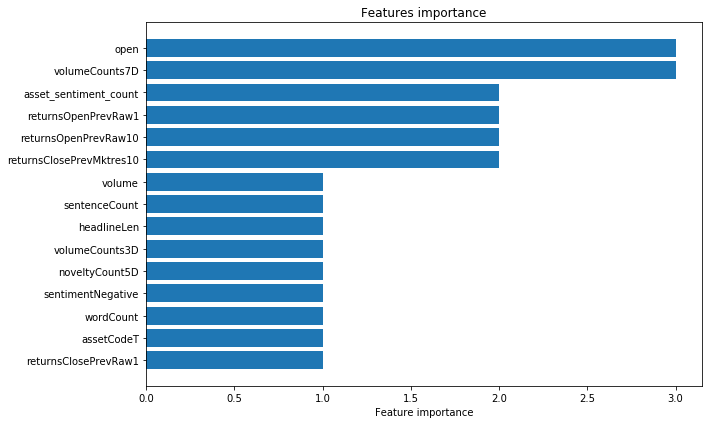

In [115]:
features_imp = pd.DataFrame()
features_imp['features'] = list(feature_columns)[:]
features_imp['importance'] = lgb_clf.feature_importances_
features_imp = features_imp.sort_values(by='importance', ascending=False).reset_index()

y = -np.arange(15)
plt.figure(figsize=(10,6))
plt.barh(y, features_imp.loc[:14,'importance'].values)
plt.yticks(y,(features_imp.loc[:14,'features']))
plt.xlabel('Feature importance')
plt.title('Features importance')
plt.tight_layout()